# Scatering Network for Seismology -- PLOTTING

This notebook reproduces the tutorials from the SCATSEISNET package.

the package is ultra minimal. I needed the following installation commands to make it work
```bash
ipython kernel install --name "ESS590D_env" --user
```
After that you can start a jupyter notebook.

Load packages

In [1]:
import os
import io
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import obspy
from obspy.clients.fdsn.client import Client
client = Client('IRIS')
import sklearn
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scatseisnet import ScatteringNetwork
# %config InlineBackend.figure_format = "svg"

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Create folder

In [2]:
# model (octave, resolution,quality)
str_network = 'o4_r4_q1_o5_r2_q2'
# duration
duration = '2month'
# month = 'apr'
# seismic station
str_station = 'multistation'

# path to load and save averything exept of figures
dirpath_load = '/data/wsd03/data_manuela/MtStHelens/scatseisnet/{}/{}/{}'.format(str_network,duration,str_station)
print(dirpath_load)

# path to save figures
dirpath_save = '/home/koepflma/ESS590D_Manuela_Koepfli/plots/scatseisnet/{}/{}/{}'.format(str_network,duration,str_station)
print(dirpath_save)
os.makedirs(dirpath_save, exist_ok=True) # bild path to save figures if it does not exist yet

/data/wsd03/data_manuela/MtStHelens/scatseisnet/o4_r4_q1_o5_r2_q2/2month/multistation
/home/koepflma/ESS590D_Manuela_Koepfli/plots/scatseisnet/o4_r4_q1_o5_r2_q2/2month/multistation


In [16]:
os.makedirs('../output/figure', exist_ok=True)
dirpath = '../output/'

### Scattering network parameters

Copy pasted from the github:

the number of octaves ( J, int) covered by the filter banks per layer. This defines the frequency range of analysis of the input data, from the Nyquist frequency fn down to fn/2^J , and should be decided according to the frequency range of interest for the task.

the resolution ( Q, int) represents the number of wavelets for each octave, so the frequency resolution of the filterbank. This should be large for the first layer (dense) and small for the other layers (sparse), as indicated in Andén and Mallat (2014).

the quality factor (float) is the ratio between the center frequency of every wavelet and the bandwidth. Because we work with constant-Q filters, this is defined from the entire filter bank. The lower the quality factor, the more redundant the information in the scattering coefficients. We suggest using a quality factor 1 at the first layer, and a larger at the remaining layers.

### Create scatnet

In the several papers on the topic, the authors have used the Gabor wavelet. In the packaged python script, they only offer the Morlet wavelet. We will try that out!

In [7]:
network = pd.read_pickle(dirpath+"data/scattering_network.pickle")
network

ScatteringNetwork(bins=3000, sampling_rate=50.0, len=2)
ComplexMorletBank(bins=3000, octaves=4, resolution=4, quality=1, sampling_rate=50.0, len=16)
ComplexMorletBank(bins=3000, octaves=5, resolution=2, quality=2, sampling_rate=50.0, len=10)

Visualize the filter bank

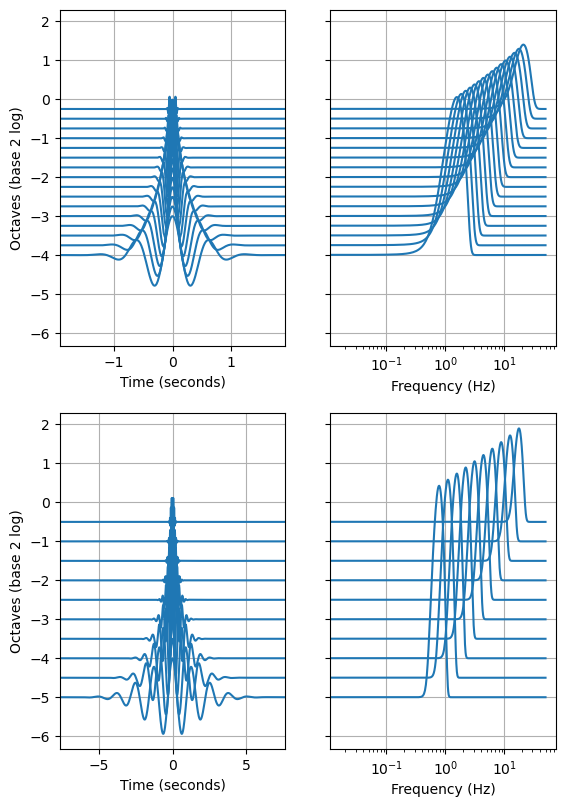

In [18]:
# Create axes (left for temporal, right for spectral domain)
fig, ax = plt.subplots(len(network.banks), 2, sharey=True, figsize=(6.4,4.8*2))

for i, bank in enumerate(network.banks):

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(bank.wavelets, bank.spectra, bank.ratios):
        # Time domain
        ax[i, 0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        ax[i, 1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of the largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    ax[i, 0].set_ylabel("Octaves (base 2 log)")
    ax[i, 0].set_xlabel("Time (seconds)")
    ax[i, 0].set_xlim(-width_max, width_max)
    ax[i, 0].grid()
    ax[i, 1].set_xscale("log")
    ax[i, 1].set_xlabel("Frequency (Hz)")
    ax[i, 1].grid()

# # Save figure with index as part of the filename
plt.savefig(dirpath + 'figure/network.png', dpi=300, bbox_inches='tight')
# Show
plt.show()


In [20]:
# Load data from file
with np.load(dirpath+"data/scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]
    list_netstacha=data["list_netstacha"]
times.shape, order_1.shape,order_2.shape


((5759,), (5759, 3, 16), (5759, 3, 16, 10))

In [21]:
# Extract the first channel
channel_id = 0
timestamps = times.copy()
o_1 = np.log10(order_1[:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers


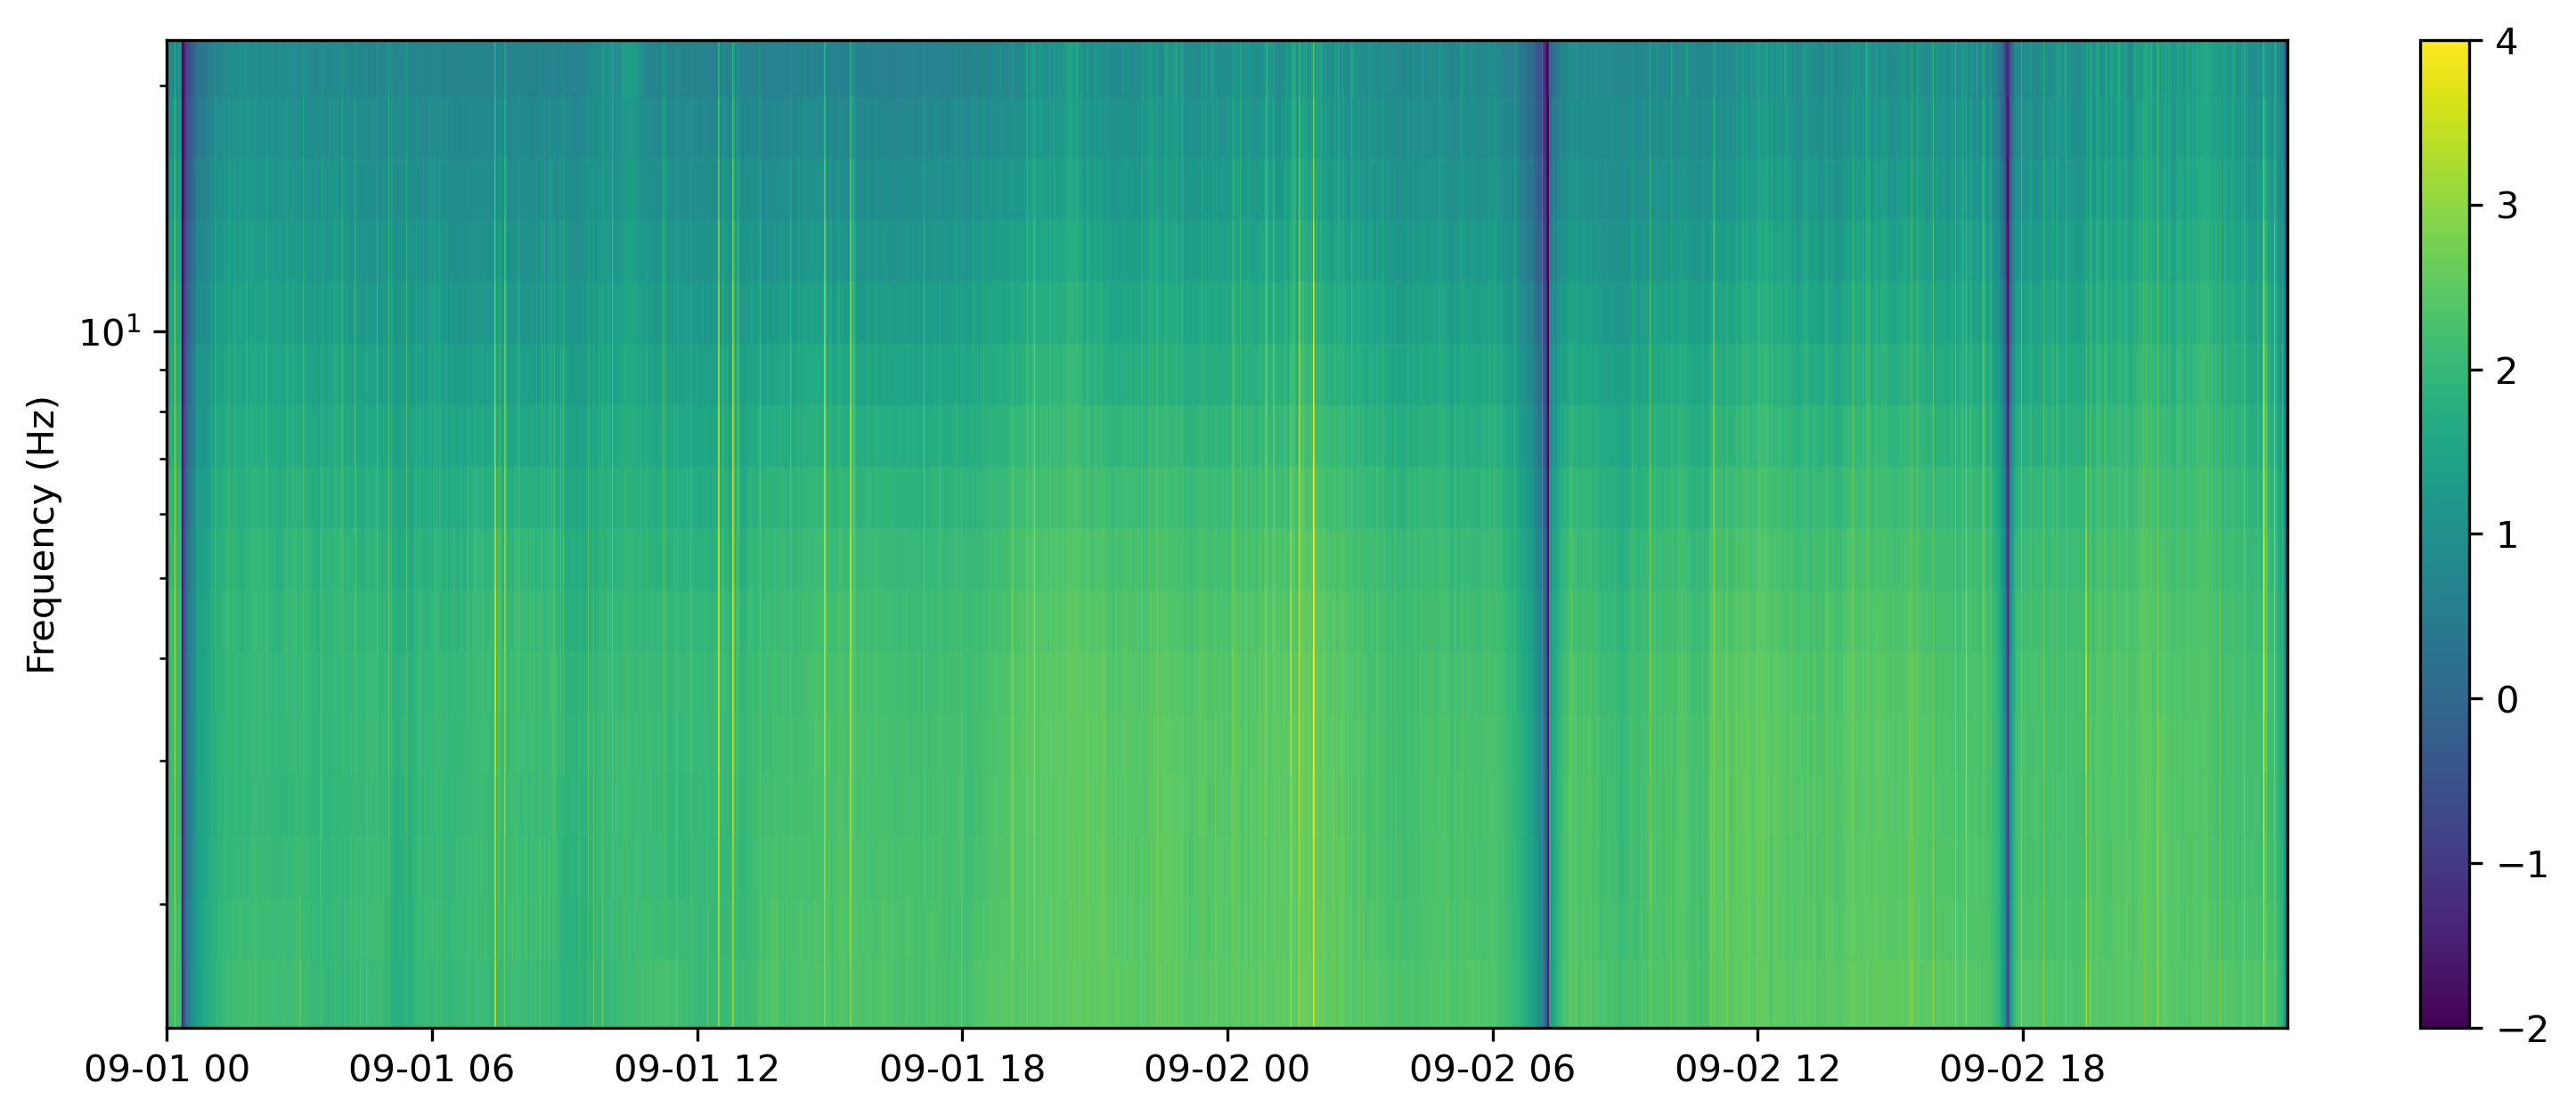

In [22]:
# Create figure and axes
fig, ax = plt.subplots(sharex=True, dpi=300, figsize=(6.4*2,4.8))

# First-order scattering coefficients
im = ax.pcolormesh(timestamps, center_frequencies, o_1.T, rasterized=True, vmin=-2,vmax=4)

# Axes labels
ax.set_yscale("log")
ax.set_ylabel("Frequency (Hz)")

fig.colorbar(im)
plt.savefig(dirpath+'figure/o1_scatcoefs.png', dpi=300, bbox_inches='tight')
# Show
plt.show()


In [23]:
# Reshape and stack scattering coefficients of all orders

order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))


Collected 5759 samples of 528 dimensions each.


## Dimensionality reduction

This tutorial uses FastICA for the dimensionality reduction, but we can try other things

In [24]:
model_latent = FastICA(n_components=5, whiten="unit-variance") #, random_state=42
features = model_latent.fit_transform(scattering_coefficients)

In [25]:
# Save the features
np.savez(
    dirpath+"data/independent_components.npz",
    features=features,
    times=times,
)

# Save the dimension reduction model
with open(dirpath+"data/dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        model_latent,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )
    

In [26]:
# Load features
features = np.load(dirpath+"data/independent_components.npz", allow_pickle=True)['features']
times = np.load(dirpath+"data/independent_components.npz", allow_pickle=True)['times']
print(features.shape,times.shape)
# Load the dimension reduction model
model_latent = pd.read_pickle(dirpath+"data/dimension_model.pickle")
model_latent

(5759, 5) (5759,)


FastICA(n_components=5)

Plots the features

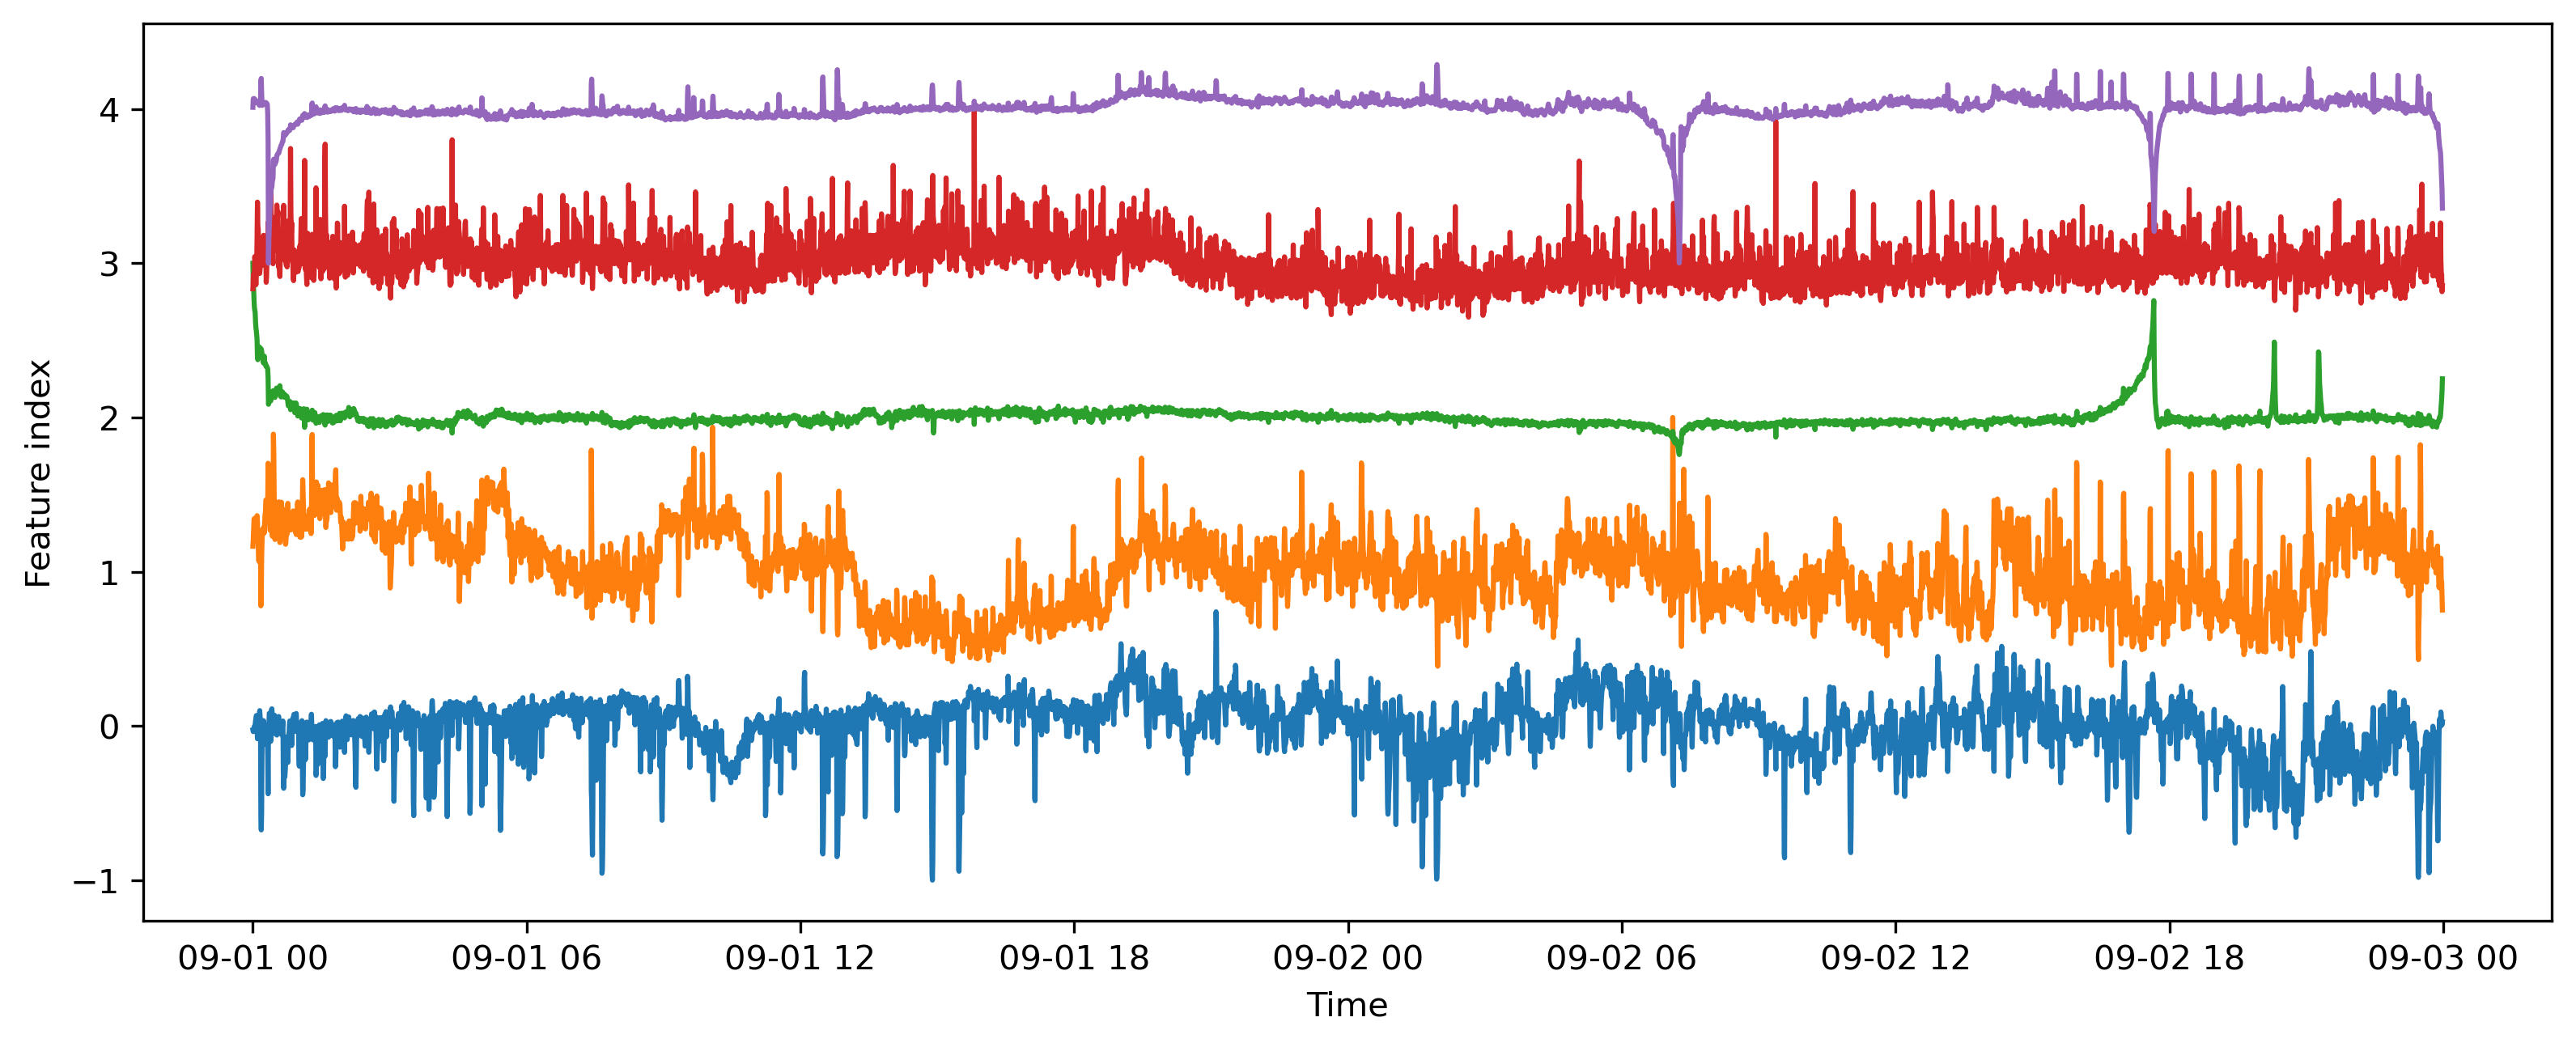

In [28]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=300, figsize=(6.4*2,4.8))
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Time")
plt.savefig(dirpath+'figure/features.png', dpi=300, bbox_inches='tight')
# Show
plt.show()


## Clustering

We will use Kmeans here. Reload the models to make things fresh

In [29]:
N_CLUSTERS = 7

# Perform clustering
model_cluster = KMeans(n_clusters=N_CLUSTERS, n_init='auto', random_state=4)
model_cluster.fit(features)

# Predict cluster for each sample
predictions = model_cluster.predict(features)
# Calculate centroids of clusters
centroids = np.abs(model_cluster.cluster_centers_)


In [31]:
# Save the prediction
np.savez(
    dirpath+"data/predictions_cl{}.npz".format(N_CLUSTERS),
    predictions=predictions,
)

# Save the centroids
np.savez(
    dirpath+"data/centroids_cl{}.npz".format(N_CLUSTERS),
    centroids=centroids,
)

Vizualize cluster-wise detection rate

### Plotting

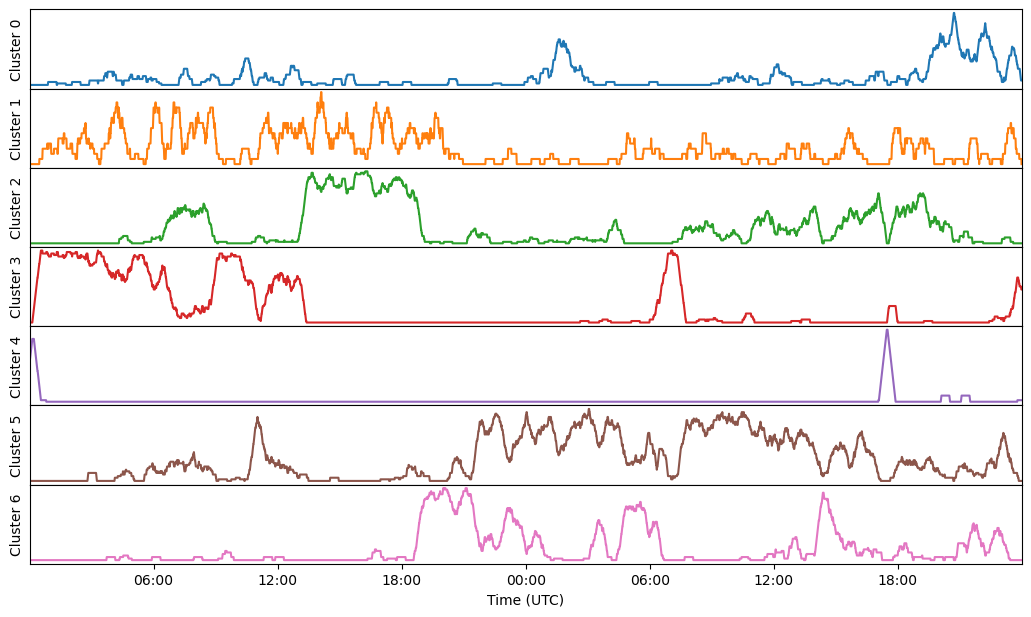

In [37]:
import datetime
import matplotlib.dates as mdates
from matplotlib.pyplot import cm
SMOOTH_KERNEL = 50

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(N_CLUSTERS,1,sharex=True,figsize=(6.4*2, 4.8*1.5))
fig.subplots_adjust(hspace=0)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax[i].plot(times, detection_rate, color="C{}".format(i))
        
    # Y-Label
    ax[i].set_yticks([])
    ax[i].set_ylabel("Cluster {}".format(i))

# X-Label
ax[i].set_xlabel("Time (UTC)")
ax[i].set_xlim(times[0],times[-1])
ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))

plt.savefig(dirpath+'figure/timeseries_cl{}.png'.format(N_CLUSTERS), dpi=300, bbox_inches='tight')
plt.show()

## Read mseed

In [41]:
st = obspy.read(dirpath+"data/scattering_stream.mseed", format="MSEED")
st

3 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-03T00:00:00.080100Z | 50.0 Hz, 8640005 samples
UW.SHW..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-03T00:00:00.100100Z | 50.0 Hz, 8640006 samples
UW.HSR..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-03T00:00:00.060100Z | 50.0 Hz, 8640004 samples

## continue

In [99]:
N_WAVEFORMS = 20

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
means = list()
distances = list()
closests = list()

# cl_list = [0,3,5,6,7,8,9,11] #<-------------------------------------------------------------------------------select the clusters
# cl_list = [1,2,4,10,12]
# cl_list = [0,3,6,8,11] # to represent merged clusters [0,5],[3,7],[6,9],[8],[11]

# for cluster in cl_list:
for cluster in np.unique(predictions):
    print('Cluster {}'.format(cluster))
    
    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times[predictions == cluster][distance.argsort()[:N_WAVEFORMS]]
    means.append(mean)
    distances.append(distance)
    closests.append(closest)

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        trace = stream_merge.slice(time, time + waveform_duration)[0].copy()
        traces.append(trace)
    waveforms.append(traces) # all waveforms from one station!!

    
# np.savez(dirpath_load+"/distances_cl{}.npz".format(N_CLUSTERS),
#          means=np.asarray(means),distances=np.asarray(distances, dtype=object), closests=closests[0])
print('***done***')

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6
***done***


In [35]:
distances_centroid = list()
for cent in centroids:
    distance_centroid = np.linalg.norm(features[predictions == cluster] - cent, axis=1)
    distances_centroid.append(distance_centroid)

In [7]:
# load the means, closests (times), distances
means = np.load(dirpath_load+"/distances_cl{}.npz".format(N_CLUSTERS), allow_pickle=True)['means']
closests = np.load(dirpath_load+"/distances_cl{}.npz".format(N_CLUSTERS), allow_pickle=True)['closests']
# because distances is a list of arrays with different length we have to rebuilt this list by loading each array seperatly
distances = np.load(dirpath_load+"/distances_cl{}.npz".format(N_CLUSTERS), allow_pickle=True)['distances']
             #[key] for key in np.load(dirpath_load+"/distances_cl{}.npz".format(N_CLUSTERS), allow_pickle=True).files[2:]]

Get cluster coordinates in the feature space

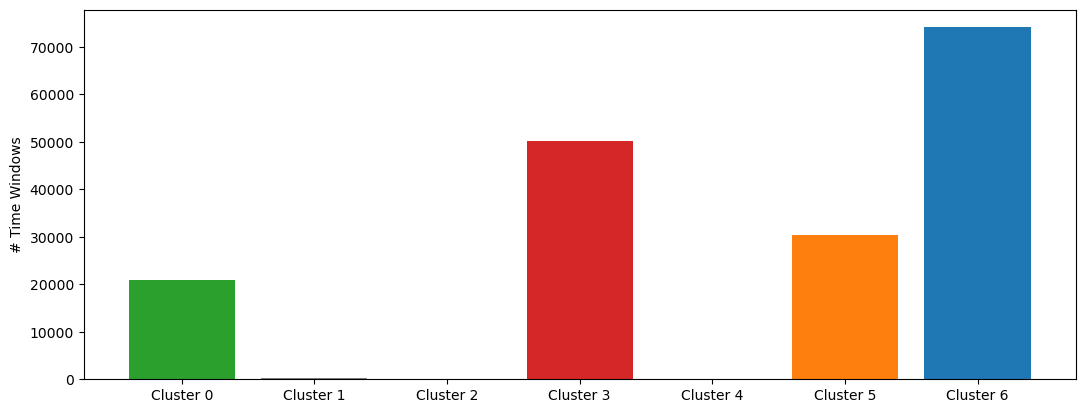

In [61]:
# plot the number of time windows in each cluster
plt.figure(figsize=(6.4*2,4.8))
for i, (dist,col) in enumerate(zip(distances,['C2','gray','gray','C3','gray','C1','C0'])):
#     plt.bar(i,dist.shape,color='C{}'.format(i))
    plt.bar(i,dist.shape,color=col)

plt.xticks(range(len(distances)), ['Cluster {}'.format(i) for i in range(len(distances))])
plt.ylabel('# Time Windows')
plt.savefig(dirpath_save+'/barplot_timewindows_cl{}.png'.format(N_CLUSTERS), dpi=300, bbox_inches='tight')

Text(0.5, 0.01, '# Time Windows')

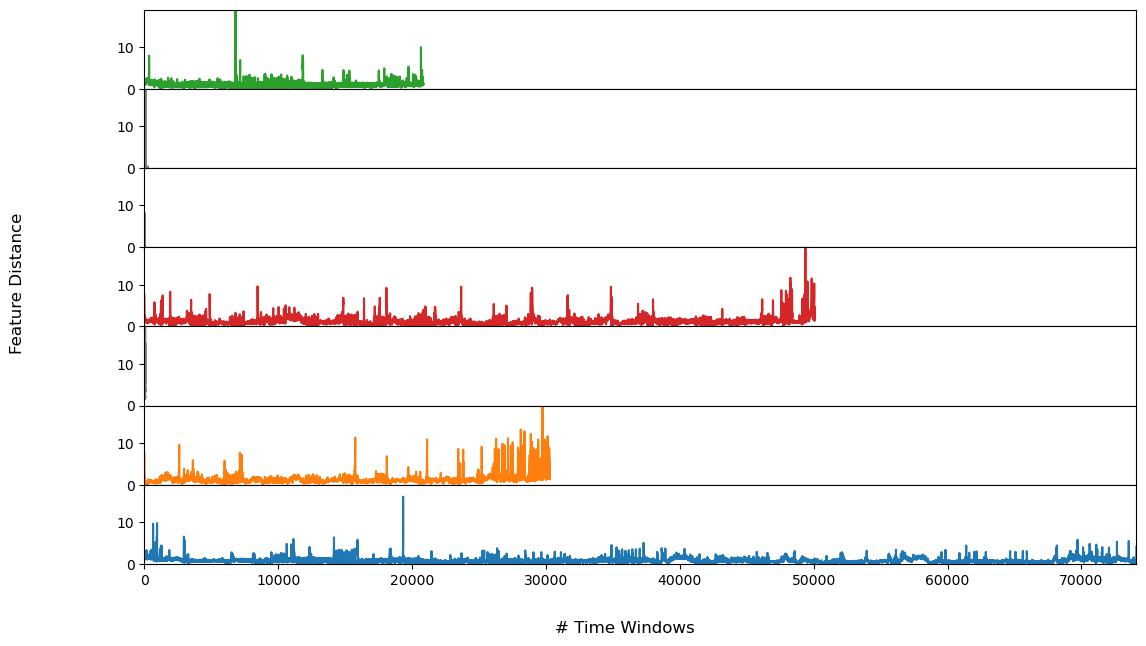

In [57]:
# plot distances of features for the different clusters
fig, ax = plt.subplots(N_CLUSTERS, 1,sharex=True,figsize=(6.4*2,4.8*1.5))#,constrained_layout=True
fig.subplots_adjust(hspace=0)
for i,(dist,col) in enumerate(zip(distances,['C2','gray','gray','C3','gray','C1','C0'])):
#     ax[i].plot(range(len(dist)),dist,color='C{}'.format(i))
    ax[i].plot(range(len(dist)),dist,color=col)
    ax[i].set_xlim(0,len(max(distances, key=len)))
    ax[i].set_ylim(0,max(max(distances, key=tuple)))
fig.supylabel('Feature Distance')
fig.supxlabel("# Time Windows")
# plt.savefig(dirpath_save+'/distance_features_cl{}.png'.format(N_CLUSTERS), dpi=300, bbox_inches='tight')

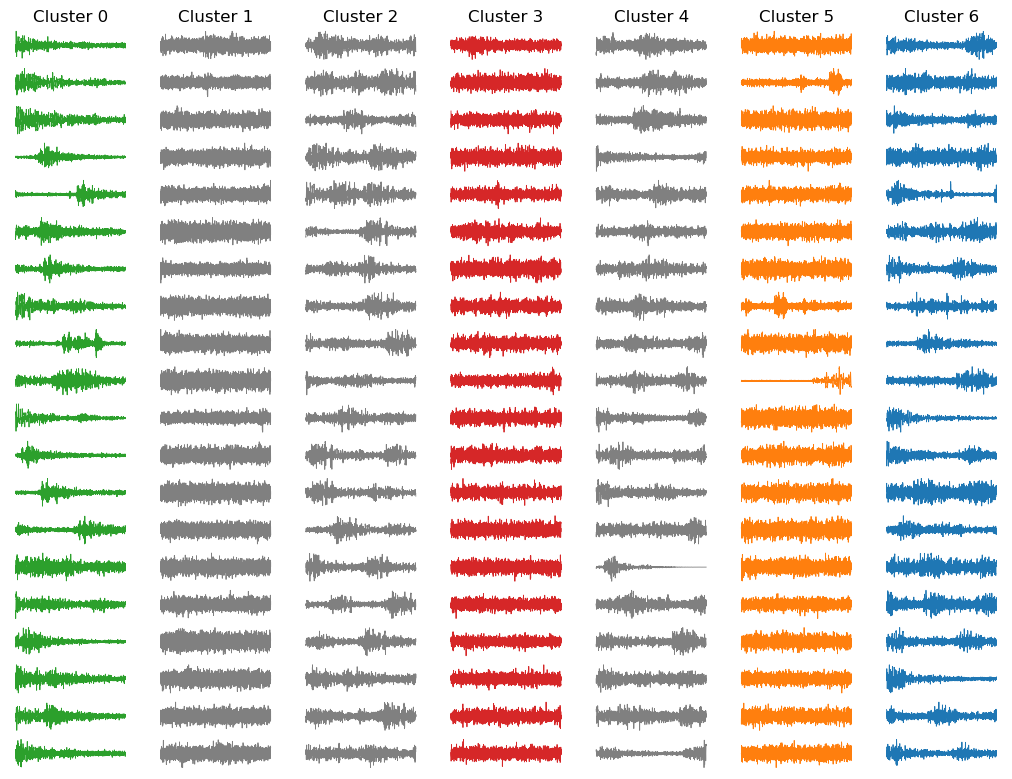

In [100]:
# Plot the results with NORMALIZATION
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, figsize=(6.4*2,4.8*2))

# Plot each cluster as a separate line
for i, (traces,col) in enumerate(zip(waveforms[:N_WAVEFORMS],['C2','gray','gray','C3','gray','C1','C0'])):
    ax[0, i].set_title(f"Cluster {i}") #, rotation="vertical"
    for j, trace in enumerate(traces):
        trace_norm = trace.data /max(abs(trace.data))
        ax[j, i].plot(trace.times(), trace_norm, rasterized=True, lw=0.6, color=col)
        ax[j, i].set_axis_off()

plt.savefig(dirpath_save+f'/waveforms_norm_{sta}_cl{N_CLUSTERS}select_final.png'
            , dpi=300, bbox_inches='tight')
# Show
plt.show()

## Spectrum

In [27]:
st_copy = stream_merge.copy()
stream = obspy.Stream()
for windowed_st in st_copy.slide(window_length=60.0, step=30.0):
    stream += windowed_st[0]
stream

175679 Trace(s) in Stream:

UW.SHW..EHZ | 2004-09-01T00:00:00.000100Z - 2004-09-01T00:01:00.000100Z | 100.0 Hz, 6001 samples
...
(175677 other traces)
...
UW.SHW..EHZ | 2004-10-31T23:59:00.000100Z - 2004-11-01T00:00:00.000100Z | 100.0 Hz, 6001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [40]:
x = 100 # das wievielte element genommen wird
NFFT=int(60*100)  # 30s * 100Hz
Pxx_arr = np.full((len(range(0,len(stream),x)), int(NFFT/2.+1)), np.nan)  # do not hard-code

for i in range(0,len(stream),x):
    
    tr_slice = stream[i]

    tr_slice.detrend('linear')
    Pxx, freqs = plt.psd(tr_slice.data, Fs=tr_slice.stats.sampling_rate, NFFT=int(NFFT))
    Pxx_arr[int(i/x),:] = Pxx
    plt.close()

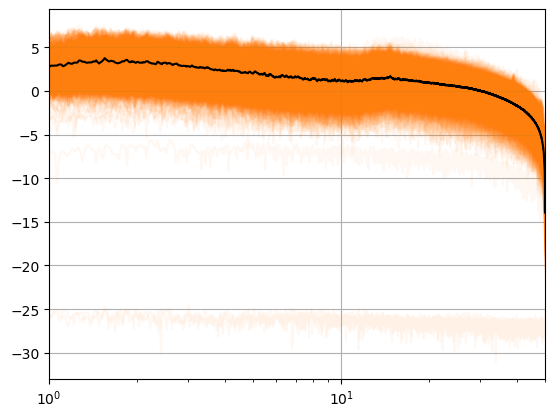

In [41]:
for i in range(Pxx_arr.shape[0]):
    plt.plot(freqs, np.log10(Pxx_arr[i,:]), color='C1', alpha=0.05)
plt.plot(freqs, np.median(np.log10(Pxx_arr), axis=0), color='k')
plt.xscale('log')
plt.xlim(1,50)
plt.grid()

### Time of interesst

In [30]:
predictions

array([3, 3, 3, ..., 6, 6, 6], dtype=int32)

In [31]:
from obspy import UTCDateTime
import datetime
import time

# cl_list = [0,3,5,6]
# colors = ['C2','C3','C1','C0']

cl_list = [5,3,6,0]
colors = ['C1','C3','C0','C2']

In [32]:

Pxx_dict = {}

tr = stream_merge[0]

fig, ax = plt.subplots()
for cl,color in zip(cl_list, colors):
    idx_select = predictions==cl
    times_select = times[idx_select]
    times_select = times_select[::100]  # !!!sloppy

    NFFT=int(30*100)  # 30s * 100Hz
    Pxx_arr = np.full((len(times_select), int(NFFT/2.+1)), np.nan)  # do not hard-code
    
    start_timer = time.time()
    for i, s_time in enumerate(times_select):
        print(i, end='\r')
        tr_slice = tr.slice(UTCDateTime(s_time), UTCDateTime(s_time+datetime.timedelta(seconds=30)))
        tr_slice.detrend('linear')
        Pxx, freqs = plt.psd(tr_slice.data, Fs=tr_slice.stats.sampling_rate, NFFT=int(NFFT))
        Pxx_arr[i,:] = Pxx
#         print('{:.1f} seconds to run ...'.format((time.time()-start_timer)/(i+1)*(len(times_select)-i+1)) , end='\r')
    Pxx_dict[cl] = Pxx_arr
    plt.close()

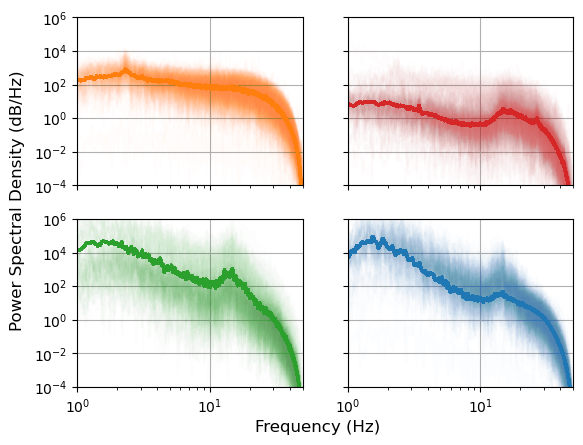

In [35]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(2, 2, figsize=(6.4, 4.8), sharex=True, sharey=True)

for i, (cl, color) in enumerate(zip(cl_list, colors)):
    Pxx_arr = Pxx_dict[cl]

    # Determine subplot indices based on the iteration
    if i == 0:
        subplot_indices = (0, 0)
    elif i == 1:
        subplot_indices = (0, 1)
    elif i == 2:
        subplot_indices = (1, 1)
    elif i == 3:
        subplot_indices = (1, 0)

    for ttr in range(100):
        # Plot data in the corresponding subplot
        ax[subplot_indices].plot(freqs, np.log10(Pxx_arr[ttr, :]), color=color, alpha=0.01)
        ax[subplot_indices].plot(freqs, np.mean(np.log10(Pxx_arr), axis=0), color=color, linewidth=2)

    # Format y-tick labels in scientific notation
    ax[subplot_indices].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"10$^{{{int(x)}}}$"))

    # Set common formatting options for the subplot
    ax[subplot_indices].set_xscale('log')
    ax[subplot_indices].set_xlim(1, 50)
    ax[subplot_indices].set_ylim(-4, 6)
    ax[subplot_indices].grid()

fig.supxlabel('Frequency (Hz)')
fig.supylabel('Power Spectral Density (dB/Hz)')
# plt.savefig(dirpath_save+'/psd_cl{}_select_grid_{}.png'.format(N_CLUSTERS,sta), dpi=300, bbox_inches='tight')
plt.show()


## Elbow curve

In [7]:
sse = np.load("../output/data/sse.npz", allow_pickle=True)['sse']
sse

array([878390.        , 746536.76632642, 664167.41845809, 517257.8572332 ,
       412736.7533947 , 326546.56717114, 278273.50920906, 250992.2112575 ,
       234876.69214737, 221206.31669889, 191940.25759343, 172216.52191623,
       162806.84274324, 155538.03485838, 146534.37807614, 142037.16773619,
       135855.07190089, 133326.27383668, 129513.61108346, 126771.35383144])